In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
walltime = "01:00:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    processes=cores,
    job_extra_directives=[
        "-q normal",
        "-P dt6",
        "-l ncpus="+str(cores),
        "-l mem="+str(memory),
        "-l storage=gdata/w42+gdata/rt52+gdata/ob53+scratch/w42"
        # "-l storage=gdata/xp65"
    ],
    local_directory="$TMPDIR",
    job_directives_skip=["select"],
    # python="/g/data/xp65/public/apps/med_conda_scripts/analysis3-25.08.d/bin/python",
    # job_script_prologue=['module load conda/analysis3-25.08'],
    log_directory="/scratch/w42/dr6273/tmp/logs"
)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40769 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/40769/status,
Dashboard: /proxy/40769/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.2:42643,Workers: 0
Dashboard: /proxy/40769/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import glob

import matplotlib.pyplot as plt

## Load data

Capacity factor

In [6]:
cf_paths = sorted(glob.glob("/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/*.zarr"))

In [38]:
cf_paths = cf_paths[32:-1]

In [39]:
datasets = [xr.open_zarr(p, chunks={}) for p in cf_paths]

In [40]:
cf = xr.combine_by_coords(datasets, compat="override", data_vars="minimal", coords="minimal")

In [41]:
cf = cf.cf100m

In [42]:
cf

<xarray.DataArray 'cf100m' (time: 341856, lat: 737, lon: 506)> Size: 510GB
dask.array<concatenate, shape=(341856, 737, 506), dtype=float32, chunksize=(72, 737, 506), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B ...
    height   float64 8B ...
  * lat      (lat) float64 6kB -43.37 -43.33 -43.29 ... -14.01 -13.97 -13.93
  * lon      (lon) float64 4kB 133.5 133.5 133.6 133.6 ... 153.6 153.7 153.7
  * time     (time) datetime64[ns] 3MB 2011-01-01 ... 2023-12-31T23:40:00

REZ mask

In [43]:
rez_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_BARRA-C2_grid.nc"
)["REZ"]

### Analysis

In [13]:
r = "Q1"

In [16]:
r_cf = cf.where(rez_mask.sel(region=r), drop=True)

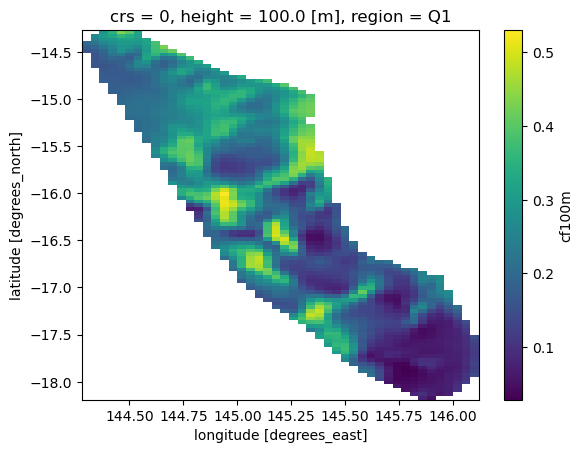

In [18]:
r_cf.mean("time").plot()

In [19]:
import pandas as pd

In [44]:
rez_means = pd.DataFrame(index=rez_mask.region.values, columns=["raw_mean"])

In [45]:
for r in rez_means.index:
    r_cf = cf.where(rez_mask.sel(region=r), drop=True)
    rez_means.loc[r] = r_cf.mean().values

In [46]:
rez_means

,raw_mean
Q1,0.239912
Q2,0.193525
Q3,0.150732
Q4,0.15786
Q5,0.231247
Q6,0.161351
Q7,0.138068
Q8,0.1772
Q9,0.136025
N1,0.165154


In [48]:
# Write the capacity factor stats to file
rez_means.to_csv(
    "/scratch/w42/dr6273/BARRA-C2/derived/wind_capacity_factor/capacity_factor_REZ_mean_2011-2023.csv"
)

In [49]:
# Load AEMO obs and ERA5 REZ stats
cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel/bias_corrected/"

cf_stats = pd.read_csv(
    cf_path + "wind_medium_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
    index_col=0
)

In [50]:
cf_stats

,obs_mean,raw_mean,bc_mean
Q1,0.42,0.099753,0.421533
Q2,0.33,0.093495,0.328461
Q4,0.30,0.075578,0.303077
Q5,0.30,0.122847,0.296149
Q6,0.32,0.068592,0.317690
Q7,0.29,0.071277,0.286156
Q8,0.32,0.086247,0.323846
Q9,0.25,0.056128,0.250771
N2,0.37,0.077789,0.370003
N3,0.33,0.103789,0.332306


Text(0.5, 0, 'REZ')

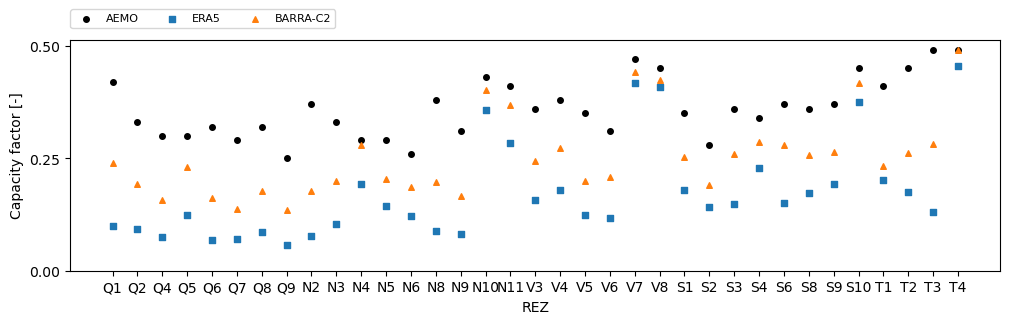

In [64]:
fig, ax = plt.subplots(figsize=(12,3))
s = 16
ylim = 0.5

cf_stats.reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
cf_stats.reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="ERA5")
rez_means.loc[cf_stats.index].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:orange", s=s, marker="^", label="BARRA-C2")
ax.legend(ncols=3, fontsize=8, loc=(0, 1.05))
ax.set_yticks([0, ylim/2, ylim])
ax.set_ylabel("Capacity factor [-]")
ax.set_xlabel("REZ")